Intensity and $K_D$ Analysis
===

In [1]:
####################################################################################
#                                                                                  #
# Leave these values blank to let the script determine them automatically.         #
# Only set them if something goes wrong!                                           #
#                                                                                  #
####################################################################################
flow_cell_id = ''
target_name = ''
neg_control_target_name = ''
all_channels = []
data_channel = ''
target_sequence_file = "/shared/targets.yml"
#nonneg_lda_weights_fpath = '/shared/yeast_beast_LDA_weights.txt'  # for microscope 3
nonneg_lda_weights_fpath = '/shared/bLDA_coef_nonneg.txt'  # for microscope 2 and 4
MINIMUM_CLUSTER_PER_SEQUENCE = 5

In [24]:
from collections import defaultdict
import flabpal
import glob
import h5py
import itertools
import lomp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pkg_resources
import progressbar
import random
import re
from scipy import stats
import sys
import yaml
from champ import misc, intensity, initialize, seqtools, gbtools, interactive
from champ.kd import fit_all_kds, saturated_at_concentration, fit_one_group_kd

try:
    matplotlib.style.use('flab')
except:
    pass

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
flow_cell_id = interactive.determine_flow_cell_id(flow_cell_id)
target_name = interactive.load_config_value('perfect_target_name', target_name)
neg_control_target_name = interactive.load_config_value('neg_control_target_name', neg_control_target_name)
all_channels = list(map(str, initialize.determine_channel_names('.'))) if not all_channels else all_channels
alignment_channel = interactive.load_config_value('alignment_channel', data_channel)
data_channel = interactive.determine_data_channel(all_channels, alignment_channel)

In [4]:
read_name_dir = os.path.join('/shared', flow_cell_id, 'read_names')
bamfile_path = os.path.join('/shared', flow_cell_id, 'all_fastqs', 'genomic.bam')
read_name_kd_filename = os.path.join('results', 'cluster-data.h5')
read_names_by_seq_fpath = os.path.join(read_name_dir, 'read_names_by_seq.txt')

In [5]:
with open(target_sequence_file) as f:
    targets = yaml.load(f)

target = targets[target_name]
neg_control_target = targets[neg_control_target_name]
commit = misc.load_commit()

print('Flow Cell ID: {}'.format(flow_cell_id))
print('Target {}: {}'.format(target_name, target))
print('Neg control target {}: {}'.format(neg_control_target_name, neg_control_target))
print('Channels: {}'.format(all_channels))
print('Protein channel: {}'.format(data_channel))
print('Output file: {}'.format(read_name_kd_filename))
print('Git commit used for this analysis: {}'.format(commit))

Flow Cell ID: SA17063
Target D: TTTAGTGATAAGTGGAATGCCATGTGG
Neg control target A: AAGGCCGAATTCTCACCGGCCCCAAGGTATTCAAG
Channels: ['Alexa488_blue']
Protein channel: Alexa488_blue
Output file: results/cluster-data.h5
Git commit used for this analysis: 8742046f74395572ca939385209b10fcc3da8a08


### Find all synthetic library sequences for this target

In [6]:
interesting_seqs = set()
    
stretch = set()
for i in range(1, len(target)+1):
    stretch.update(seqtools.get_stretch_of_complement_seqs(target, i))
insertions = set()
for i in range(1, 3):
    insertions.update(seqtools.get_contiguous_insertion_seqs(target, i))
for i in range(1, 3):
    insertions.update(seqtools.get_insertion_seqs(target, i))   
deletions = set()
for i in range(1, 3):
    deletions.update(seqtools.get_deletion_seqs(target, i))
mismatches = set()
for i in range(1, 3):
    mismatches.update(seqtools.get_mismatch_seqs(target, i))
six_n_pam = seqtools.get_randomized_pam_seqs(target, 4, 6)
other_targets = set()
for s in targets.values():
    other_targets.add(s)

interesting_seqs.update(other_targets)
interesting_seqs.update(stretch)
interesting_seqs.update(insertions)
interesting_seqs.update(deletions)
interesting_seqs.update(mismatches)
interesting_seqs.update(six_n_pam)

print("Interesting sequences: %d" % len(interesting_seqs))

Interesting sequences: 11357


### Create Interesting Sequence Read Names File

In [7]:
from champ.seqtools import build_interesting_sequences
interesting_read_names_filename = os.path.join(read_name_dir, 'interesting_{target_name}_reads_by_seq.txt'.format(target_name=target_name))
if os.path.exists(interesting_read_names_filename):
    # No need to recalculate, we can just load this from disk
    interesting_read_names = {}
    with open(interesting_read_names_filename) as f:
        for line in f:
            line = line.split("\t")
            sequence = line[0]
            read_names = line[1:]
            interesting_read_names[sequence] = read_names
else:
    interesting_read_names = build_interesting_sequences(read_names_by_seq_fpath, interesting_seqs)
    with open(interesting_read_names_filename, 'w') as f:
        for sequence, read_names in interesting_read_names.items():
            f.write("%s\t%s\n" % (sequence, "\t".join(read_names)))
            
print("Found read names for %d sequences of interest." % len(interesting_read_names))

Found read names for 8286 sequences of interest.


Load Data
===

In [8]:
all_read_name_fpath = os.path.join(read_name_dir, 'all_read_names.txt')
target_read_name_fpath = os.path.join(read_name_dir, 'target_{}_read_names.txt'.format(target_name.lower()))
perfect_target_read_name_fpath = os.path.join(read_name_dir, 'perfect_target_{}_read_names.txt'.format(target_name.lower()))
neg_control_target_read_name_fpath = os.path.join(read_name_dir, 'perfect_target_{}_read_names.txt'.format(neg_control_target_name.lower()))
phiX_read_name_fpath = os.path.join(read_name_dir, 'phix_read_names.txt')

all_read_names = set(line.strip() for line in open(all_read_name_fpath))
print("All read names: %d" % len(all_read_names))
target_read_names = set(line.strip() for line in open(target_read_name_fpath))
print("Target read names: %d" % len(target_read_names))
perfect_target_read_names = set(line.strip() for line in open(perfect_target_read_name_fpath))
print("Perfect target read names: %d" % len(perfect_target_read_names))
neg_control_target_read_names = set(line.strip() for line in open(neg_control_target_read_name_fpath))
print("Negative control read names: %d" % len(neg_control_target_read_names))
phiX_read_names = set(line.strip() for line in open(phiX_read_name_fpath))
print("Phix read names: %d" % len(phiX_read_names))

All read names: 8174894
Target read names: 1251349
Perfect target read names: 5476
Negative control read names: 6156
Phix read names: 1193542


In [9]:
h5_fpaths = glob.glob('*.h5')
h5_fpaths.sort(key=misc.parse_concentration)
for fpath in h5_fpaths:
    print misc.parse_concentration(fpath), fpath

1.0 20170507-SA17063-AsCpf1D908A-1nM_4.h5
2.0 20170507-SA17063-AsCpf1D908A-2nM_1.h5
4.0 20170507-SA17063-AsCpf1D908A-4nM_1.h5
8.0 20170507-SA17063-AsCpf1D908A-8nM_1.h5
16.0 20170507-SA17063-AsCpf1D908A-16nM_1.h5
32.0 20170507-SA17063-AsCpf1D908A-32nM_1.h5
64.0 20170507-SA17063-AsCpf1D908A-64nM_1.h5
128.0 20170507-SA17063-AsCpf1D908A-128nM_1.h5
256.0 20170507-SA17063-AsCpf1D908A-256nM_1.h5
512.0 20170507-SA17063-AsCpf1D908A-512nM_1.h5


In [10]:
results_dirs = [
    os.path.join('results', 
                 os.path.splitext(os.path.basename(h5_fpath))[0])
    for h5_fpath in h5_fpaths
]
for d in results_dirs:
    print(d)

results/20170507-SA17063-AsCpf1D908A-1nM_4
results/20170507-SA17063-AsCpf1D908A-2nM_1
results/20170507-SA17063-AsCpf1D908A-4nM_1
results/20170507-SA17063-AsCpf1D908A-8nM_1
results/20170507-SA17063-AsCpf1D908A-16nM_1
results/20170507-SA17063-AsCpf1D908A-32nM_1
results/20170507-SA17063-AsCpf1D908A-64nM_1
results/20170507-SA17063-AsCpf1D908A-128nM_1
results/20170507-SA17063-AsCpf1D908A-256nM_1
results/20170507-SA17063-AsCpf1D908A-512nM_1


# Determine intensities of all aligned reads

In [12]:
print 'Loading data...'
int_scores = intensity.IntensityScores(h5_fpaths)
int_scores.get_LDA_scores(results_dirs, nonneg_lda_weights_fpath)

Loading data...
20170507-SA17063-AsCpf1D908A-1nM_4.h5
Num results files: 607
20170507-SA17063-AsCpf1D908A-2nM_1.h5
Num results files: 600
20170507-SA17063-AsCpf1D908A-4nM_1.h5
Num results files: 564
20170507-SA17063-AsCpf1D908A-8nM_1.h5
Num results files: 538
20170507-SA17063-AsCpf1D908A-16nM_1.h5
Num results files: 539
20170507-SA17063-AsCpf1D908A-32nM_1.h5
Num results files: 534
20170507-SA17063-AsCpf1D908A-64nM_1.h5
Num results files: 526
20170507-SA17063-AsCpf1D908A-128nM_1.h5
Num results files: 505
20170507-SA17063-AsCpf1D908A-256nM_1.h5
Num results files: 489
20170507-SA17063-AsCpf1D908A-512nM_1.h5
Num results files: 481


In [13]:
import time
print 'Normalizing data...'
int_scores.normalize_scores()
print 'Done normalizing.'

Normalizing data...
20170507-SA17063-AsCpf1D908A-1nM_4.h5

20170507-SA17063-AsCpf1D908A-2nM_1.h5

20170507-SA17063-AsCpf1D908A-4nM_1.h5

20170507-SA17063-AsCpf1D908A-8nM_1.h5

20170507-SA17063-AsCpf1D908A-16nM_1.h5

20170507-SA17063-AsCpf1D908A-32nM_1.h5

20170507-SA17063-AsCpf1D908A-64nM_1.h5

20170507-SA17063-AsCpf1D908A-128nM_1.h5

20170507-SA17063-AsCpf1D908A-256nM_1.h5

20170507-SA17063-AsCpf1D908A-512nM_1.h5

Done normalizing.


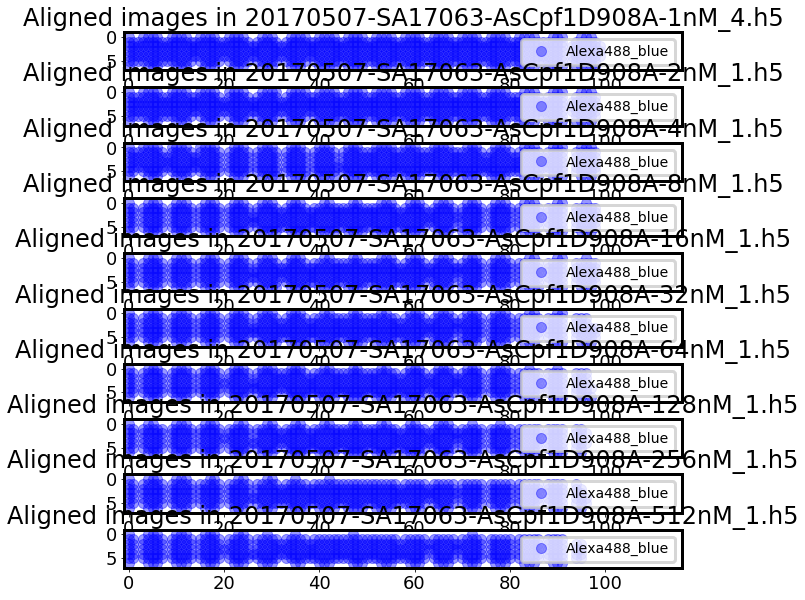

In [14]:
int_scores.plot_aligned_images('br', 'o*')

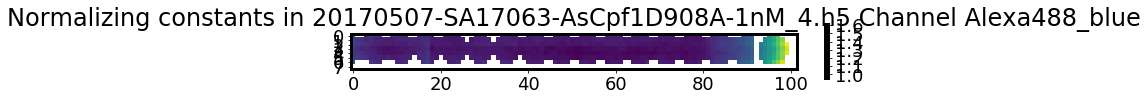

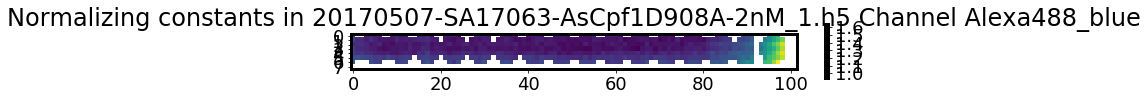

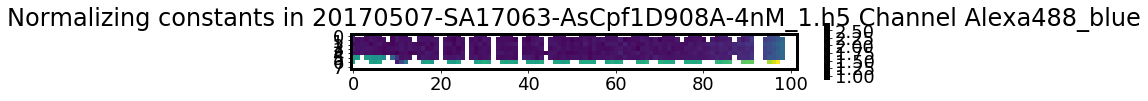

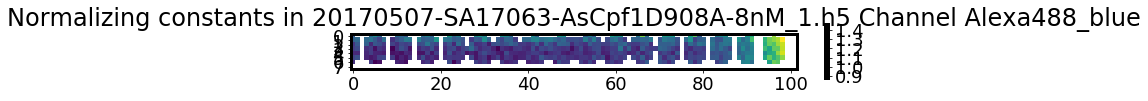

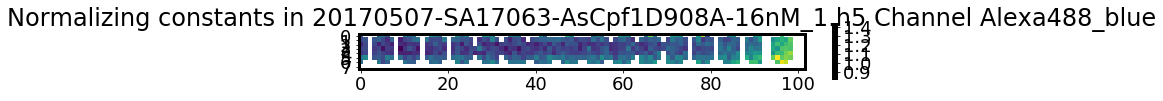

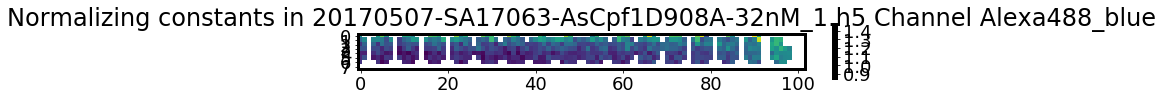

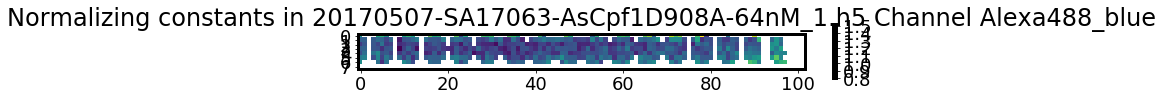

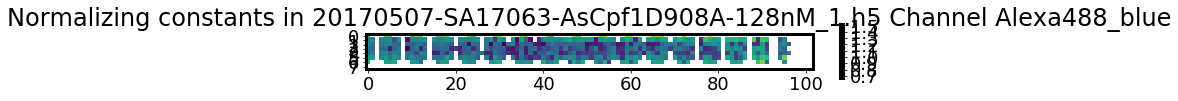

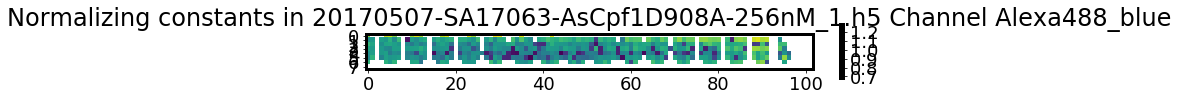

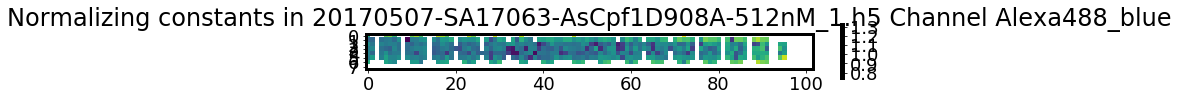

In [15]:
int_scores.plot_normalization_constants()

In [16]:
int_scores.print_reads_per_channel()

All reads found in channel Alexa488_blue: 6,898,034


In [17]:
# The number of observations we require to consider a cluster valid enough for fitting.
# Clusters at the edge of a field of view might not be visible in every concentration due to
# random imperfections in the motion of the stage, and some fields of view might simply not
# align under each concentration.
minimum_observations_per_cluster = len(h5_fpaths) - 3

int_scores.build_good_read_names(MINIMUM_CLUSTER_PER_SEQUENCE)
good_read_names = int_scores.good_read_names
good_perfect_read_names = perfect_target_read_names & good_read_names
print 'Good Reads:', len(good_read_names)
print 'Good Perfect Reads:', len(good_perfect_read_names)

Good Reads: 6159338
Good Perfect Reads: 4160


In [18]:
int_scores.build_score_given_read_name_given_channel()

20170507-SA17063-AsCpf1D908A-1nM_4.h5
20170507-SA17063-AsCpf1D908A-2nM_1.h5
20170507-SA17063-AsCpf1D908A-4nM_1.h5
20170507-SA17063-AsCpf1D908A-8nM_1.h5
20170507-SA17063-AsCpf1D908A-16nM_1.h5
20170507-SA17063-AsCpf1D908A-32nM_1.h5
20170507-SA17063-AsCpf1D908A-64nM_1.h5
20170507-SA17063-AsCpf1D908A-128nM_1.h5
20170507-SA17063-AsCpf1D908A-256nM_1.h5
20170507-SA17063-AsCpf1D908A-512nM_1.h5


In [20]:
aligned_read_names = set()
for h5_fpath in h5_fpaths:
    for d in int_scores.scores[h5_fpath][data_channel].values():
        for read_name in d.keys():
            aligned_read_names.add(read_name)
print('Aligned reads in data channel: {}'.format(len(aligned_read_names)))

Aligned reads in data channel: 6898034


### Save sequence identifiers to disk

In [21]:
string_dt = h5py.special_dtype(vlen=str)
aligned_read_names = list(sorted(aligned_read_names))

with h5py.File(read_name_kd_filename, 'w') as h5:
    h5.create_dataset('read_names', data=aligned_read_names, dtype=string_dt)

### Save cluster intensities to disk

In [22]:
read_name_intensities = defaultdict(list)
for h5_fpath in h5_fpaths:
    score_given_read_name = int_scores.score_given_read_name_in_channel[h5_fpath][data_channel]
    for read_name in aligned_read_names:
        intensity = score_given_read_name.get(read_name, np.nan)
        read_name_intensities[read_name].append(intensity)

intensity_matrix = []
for read_name in aligned_read_names:
    intensity_matrix.append(read_name_intensities[read_name])
    
intensity_matrix = np.array(intensity_matrix)

with h5py.File(read_name_kd_filename, 'a') as h5:
    h5.create_dataset('intensities', data=intensity_matrix)
    
del int_scores

### Load intensities if they're not already loaded

In [15]:
try:
    read_name_intensities
except:
    with h5py.File(read_name_kd_filename, 'r') as h5:
        aligned_read_names = h5['read_names'][:]
        intensity_matrix = h5['intensities'][:]
        read_name_intensities = {}
        for read_name, intensity_gradient in zip(aligned_read_names, intensity_matrix):
            read_name_intensities[read_name] = intensity_gradient
        aligned_read_names = set(aligned_read_names)

# Determine what a saturated cluster looks like

In [20]:
# Find the KD of the perfect target so we can determine at what concentrations the clusters
# should be saturated
sequence_read_name_intensities = defaultdict(list)
for sequence, read_names in interesting_read_names.items():
    for read_name in read_names:
        if read_name not in read_name_intensities:
            continue
        sequence_read_name_intensities[sequence].append(read_name_intensities[read_name])

all_concentrations = [misc.parse_concentration(h5_fpath) for h5_fpath in h5_fpaths]
kd, kd_uncertainty, yint, perfect_delta_y, counts = fit_one_group_kd(sequence_read_name_intensities[target], all_concentrations, delta_y=None)
print("Perfect target KD is %.1f +/- %.3f nM" % (kd, kd_uncertainty))

Perfect target KD is 4.8 +/- 0.029 nM


In [22]:
# Determine the median intensity of a saturated cluster
saturated = saturated_at_concentration(kd)
saturated_indexes = [index for index, concentration in enumerate(all_concentrations) if concentration > saturated]
if not saturated_indexes:
    # this should never happen, but we'll try to take something reasonable
    print("Warning: perfect target sequence probably did not saturate its target!")
    saturated_indexes = len(all_concentrations) - 1

saturated_intensities = []
for intensity_gradient in sequence_read_name_intensities[target]:
    for index in saturated_indexes:
        try:
            value = intensity_gradient[index]
            if not np.isnan(value):
                saturated_intensities.append(value)
        except IndexError:
            continue
median_saturated_intensity = np.median(saturated_intensities)
print("Median saturated intensity: %d (N=%d)" % (median_saturated_intensity, len(saturated_intensities)))

Median saturated intensity: 2557229 (N=15754)


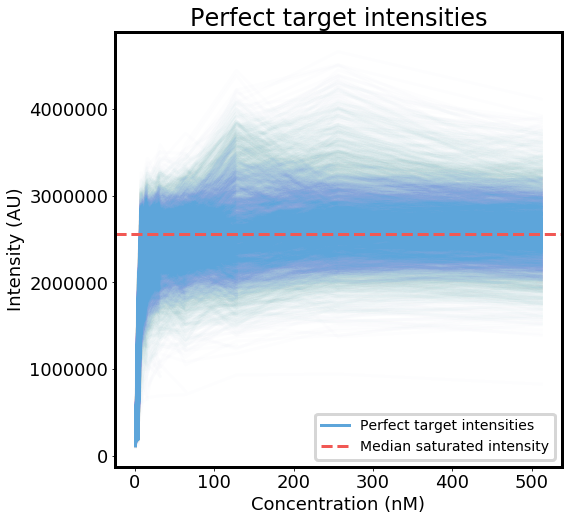

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(all_concentrations, sequence_read_name_intensities[target][0], color=flabpal.blue, alpha=0.01, label='Perfect target intensities')
for intensity_gradient in sequence_read_name_intensities[target][1:]:
    ax.plot(all_concentrations, intensity_gradient, color=flabpal.blue, alpha=0.005)
ax.axhline(median_saturated_intensity, linestyle='--', color=flabpal.red, label='Median saturated intensity');
ax.set_title("Perfect target intensities")
ax.set_ylabel("Intensity (AU)")
ax.set_xlabel("Concentration (nM)")
legend = ax.legend()
for handle in legend.legendHandles: 
    handle.set_alpha(1.0)

# Determine the KDs of all synthetic sequences

In [31]:
sequence_kds = {}
with progressbar.ProgressBar(max_value=len(sequence_read_name_intensities)) as pbar:
    for sequence, kd, kd_uncertainty, yint, delta_y, count in pbar(fit_all_kds(sequence_read_name_intensities, all_concentrations, process_count=8, delta_y=median_saturated_intensity)):
        if count >= 5:
            sequence_kds[sequence] = kd, kd_uncertainty, yint, delta_y, count
print("Found KDs for %d of %d sequences of interest" % (len(sequence_kds), len(sequence_read_name_intensities)))

100% (7997 of 7997) |####################| Elapsed Time: 0:08:20 Time:  0:08:20
100% (7997 of 7997) |####################| Elapsed Time: 0:08:20 Time:  0:08:20

Found KDs for 7940 of 7997 sequences of interest


# Save the KDs to disk

In [32]:
string_dt = h5py.special_dtype(vlen=str)
kd_dt = np.dtype([('sequence', string_dt),
                  ('kd', np.float),
                  ('kd_uncertainty', np.float),
                  ('y_intercept', np.float),
                  ('delta_y', np.float),
                  ('count', np.int32)])
with h5py.File(read_name_kd_filename, 'a') as h5:
    dataset = h5.create_dataset('synthetic-kds', (len(sequence_kds),), dtype=kd_dt)
    dataset[...] = [(sequence, kd, kd_uncertainty, yint, delta_y, count) for sequence, (kd, kd_uncertainty, yint, delta_y, count) in sequence_kds.items()]

# Save the version of software used to create this data

In [33]:
with h5py.File(read_name_kd_filename, 'a') as h5:
    group = h5.create_group("git-commit")
    group.create_group(commit)

# Statistical Overview

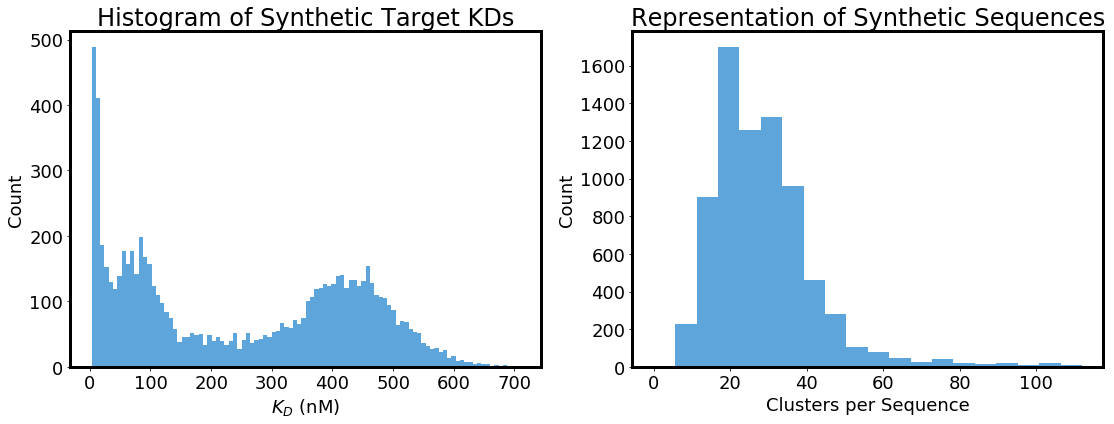

In [34]:
histogram_kds = [k[0] for k in sequence_kds.values()]
histogram_counts = [k[4] for k in sequence_kds.values()]
fig, (kd_ax, count_ax) = plt.subplots(1, 2, figsize=(16,6))
kd_ax.hist(histogram_kds, bins=100);
kd_ax.set_ylabel("Count")
kd_ax.set_xlabel("$K_D$ (nM)")
kd_ax.set_title("Histogram of Synthetic Target KDs")

count_median = np.median(histogram_counts)
count_iqr = stats.iqr(histogram_counts)
count_ax.hist(histogram_counts, bins=20, range=(0, int(count_median+count_iqr*5)))
count_ax.set_ylabel("Count")
count_ax.set_xlabel("Clusters per Sequence")
count_ax.set_title("Representation of Synthetic Sequences")
fig.tight_layout()